In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
prepath = 'parflow-melissa-da/test/2'

In [3]:


sim1_all = pd.read_csv(prepath + '/simulation-all.csv')
server_all = pd.read_csv(prepath + '/server-all.csv')

In [4]:
sim1_all

,iteration,timesteps,compute walltime (ms),idle walltime (ms),idle + compute walltime(ms)
0,0,1,668.1470,0.000000,668.1470
1,1,2,773.5080,0.900326,774.4090
2,2,2,747.9040,0.590066,748.4940
3,3,2,697.4790,0.540339,698.0200
4,4,2,135.4380,1.934340,137.3730
...,...,...,...,...,...
266,266,2,47.2144,0.536707,47.7511
267,267,2,45.2175,0.400877,45.6184
268,268,2,46.5349,1.390700,47.9256
269,269,2,47.8650,0.654761,48.5197


In [5]:
server_all

,iteration,walltime (ms),walltime filter update (ms),min_runners,max_runners,accumulated runner idle time,corresponding pdaf state per runner runner idle time,pdaf slack/melissa-da slack
0,0,2887.480,1.177080,1,1,1.465950,104.21400,71.08990
1,1,300.358,0.996913,1,1,1.175570,110.52700,94.01960
2,2,270.228,0.956197,1,1,1.169820,50.82650,43.44830
3,3,302.817,0.943802,1,1,1.157010,113.15100,97.79600
4,4,298.062,1.567040,1,1,1.839100,112.22000,61.01900
...,...,...,...,...,...,...,...,...
85,85,144.325,1.273610,1,1,1.582200,6.11946,3.86769
86,86,147.907,0.949353,1,1,1.115550,11.29780,10.12760
87,87,196.575,0.870484,1,1,1.071260,104.64700,97.68590
88,88,142.036,0.777401,1,1,0.974658,4.03463,4.13953


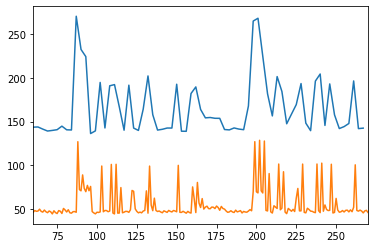

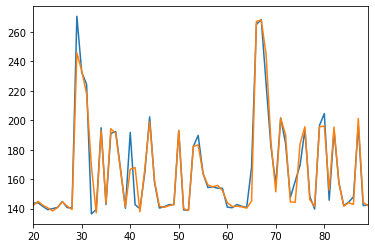

In [55]:
# cut off 20 first. as model runner calculates 3 states (3 members) each iteration we strech 
# the server side's iteration counter.

sim1_all = pd.read_csv(prepath + '/simulation-all.csv.1runners.3members')
server_all = pd.read_csv(prepath + '/server-all.csv.1runners.3members')

ys_server = server_all['walltime (ms)'][20:]
xs_server = [60+x*3 for x in range(len(server_all['walltime (ms)'][20:]))]

plt.plot(xs_server, ys_server)
sim1_all['idle + compute walltime(ms)'][60:].plot()
plt.show()

# actually the integrals shoud have the same shape. this shoulkd work quite nicely:
tmp = sim1_all['idle + compute walltime(ms)'][60:]
xs_sim = list(range(20, 90))
ys_sim = [tmp[3*x+0] + tmp[3*x+1] + tmp[3*x+2] for x in xs_sim]


server_all['walltime (ms)'][20:].plot()

plt.plot(xs_sim, ys_sim)
plt.show()

**seems really good. so on the server side we get the same as on the api side.**

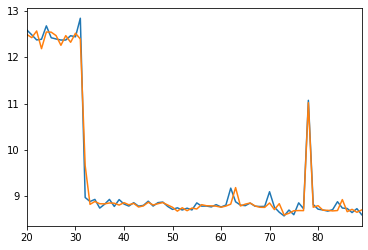

In [48]:
# cut off 20 first. as model runner calculates 1 state1 each iteration we strech 
# the server side's iteration counter.

sim1_all = pd.read_csv(prepath + '/simulation-all.csv.1runners.1members')
#                                    server-all.csv.1runners.1members
server_all = pd.read_csv(prepath + '/server-all.csv.1runners.1members')

#ys_server = server_all['walltime (ms)'][20:]
#xs_server = [60+x*3 for x in range(len(server_all['walltime (ms)'][20:]))]

#plt.plot(xs_server, ys_server)
server_all['walltime (ms)'][20:].plot()
ys_sim = sim1_all['idle + compute walltime(ms)'][20:]
xs_sim = [20+x-1 for x in range(len(sim1_all['idle + compute walltime(ms)'][20:]))]
plt.plot(xs_sim, ys_sim)
plt.show()

## Also this cross check with only one ensemble member seems legit so lets measure on the real cluster now!

# Now lets check what is our speed up in the ideal case on my machine
when assimilating parflow which uses an iterative sovler

## PDAF slack time per iteration (configured with one member per runner) / melissa-da
The case we are presenting here is the case where melissa-da is in clear advantage. for more performance more runners will be used. this adds more slacktime.... have to figure out later how much... best on a bigger machine...

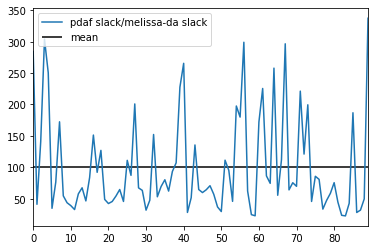

In [70]:
server_all = pd.read_csv(prepath + '/server-all.csv.1runners.9members')
server_all['pdaf slack/melissa-da slack'].plot()
plt.hlines(xmin=0, xmax=90,y=np.mean(server_all['pdaf slack/melissa-da slack']), label='mean')
plt.legend()
plt.show()

## what is the real speedup?
$Speedup=\frac{\text{pdaf runtime}}{\text{melissa-da runtime}}$

--> will depend on the amount of runners we have. but we can not be faster as pdaf as they parallelize all runners.

--> **so lets also consider the amount of resource consumption!**

$Speedup=\frac{\text{pdaf runtime (in core hours)}}{\text{melissa-da runtime (in core hours)}}$


In [81]:
server_all = pd.read_csv(prepath + '/server-all.csv.1runners.9members')

# consumption pdaf (in cores * ms):
cores = 2*9
cp = cores * (sum(server_all['walltime filter update (ms)']) + sum(server_all['max job walltime (ms)']))

# consumption melissa-da (in cores * ms):
cores = 2 + 2  # (server + one runner)
cm = cores * sum(server_all['walltime (ms)'])


print("Speedup = pdaf/melissa-da = %.2e/%.2e = %.4e" % (cp, cm, cp/cm))



Speedup = pdaf/melissa-da = 2.26e+05/2.15e+05 = 1.0545e+00


so in this case the improvement in resource consumption is small and further it takes much longer.

The melissa-da framework will only outperform if the differences in the runtime per ensemble member are big!


It keeps to say that the solver here did lots of times the same number of iterations:


In [86]:
!grep 'Nonlin. Its.' parflow-melissa-da/test/2/runner_0/pfin.out.kinsol.log

Nonlin. Its.:               7                 7
Nonlin. Its.:              18                25
Nonlin. Its.:              17                42
Nonlin. Its.:              16                58
Nonlin. Its.:              17                75
Nonlin. Its.:              28               103
Nonlin. Its.:              26               129
Nonlin. Its.:              20               149
Nonlin. Its.:              12               161
Nonlin. Its.:              18               179
Nonlin. Its.:               2               181
Nonlin. Its.:               2               183
Nonlin. Its.:               2               185
Nonlin. Its.:               2               187
Nonlin. Its.:               2               189
Nonlin. Its.:               2               191
Nonlin. Its.:               2               193
Nonlin. Its.:               2               195
Nonlin. Its.:               2               197
Nonlin. Its.:               2               199
Nonlin. Its.:               2           

In [85]:
Nonlin. Its.:               7                 7
Nonlin. Its.:              18                25
Nonlin. Its.:              17                42
Nonlin. Its.:              16                58
Nonlin. Its.:              17                75
Nonlin. Its.:              28               103
Nonlin. Its.:              26               129
Nonlin. Its.:              20               149
Nonlin. Its.:              12               161
Nonlin. Its.:              18               179
Nonlin. Its.:               2               181
Nonlin. Its.:               2               183
Nonlin. Its.:               2               185
    [....]
Nonlin. Its.:               1              1013
Nonlin. Its.:               1              1014
Nonlin. Its.:               1              1015
Nonlin. Its.:               1              1016

check_stateless.sh  README.md  run.sh
parflow-melissa-da  ref        Runtime-Measurement-Validation.ipynb


only the first iterations some more solver iterations are needed. If melissa-da is useful or not depends on the specified assimilation problem. But especially if there is rain forcing the iteration count will vary a lot ?!?

**further if ensembles get larger, single outliners (slow members) will also get more impact...!**

## is there a better speedup if we take more runners? (theoretically the server gets more load)
... try with 4 runners on 12 logic (6 real) cpus...

In [89]:
server_all = pd.read_csv(prepath + '/server-all.csv.4runners.9members')

# consumption pdaf (in cores * ms):
cores = 2*9
cp = cores * (sum(server_all['walltime filter update (ms)']) + sum(server_all['max job walltime (ms)']))

# consumption melissa-da (in cores * ms):
cores = 2 + 2*4  # (server + 4 runner)
cm = cores * sum(server_all['walltime (ms)'])


print("Speedup = pdaf/melissa-da = %.2e/%.2e = %.4e" % (cp, cm, cp/cm))



Speedup = pdaf/melissa-da = 2.92e+05/2.76e+05 = 1.0560e+00


**Voila.... now the server is less and less important....**

I think an even better speedup can be expected with even more ensemble members and more runners!

In [1]:
# TODO: do a client server comparism here too?!!! (I fear that the iteration time i'm measuring on the server side is related to the network usage)
# it scares me a bit that the speedup is again 1.05... maybe the 05 comes just from the first iterations all the time?
# we should compare more against client side measurements!

### more comparoism to client side measurements

idle time measured more per iteration (mean

In [27]:


sim_all = [pd.read_csv(prepath + '/simulation-all.csv.4runners.9members.%d' % i) for i in range(4)]
server_all = pd.read_csv(prepath + '/server-all.csv.4runners.9members')

idle_measurement_server = sum(server_all['accumulated runner idle time'])
idle_measurement_sims = sum([sum(sim['idle walltime (ms)'][1:]) for sim in sim_all])
(idle_measurement_sims - idle_measurement_server) / server_all['iteration'].shape[0]

23.650095477777885

The idle time on the simulation side is measured a bit higher. This is logic. This is the time needed for the communication. If this is really the communication time, it should not change if we do more or less iterations....

--> run with half of the iterations:

In [26]:
# changing run.sh to run with half of the iterations...
sim_all = [pd.read_csv(prepath + '/simulation-all.csv.4runners.9members.%d.90steps' % i) for i in range(4)]
server_all = pd.read_csv(prepath + '/server-all.csv.4runners.9members.90steps')

idle_measurement_server = sum(server_all['accumulated runner idle time'])
idle_measurement_sims = sum([sum(sim['idle walltime (ms)'][1:]) for sim in sim_all])
(idle_measurement_sims - idle_measurement_server) / server_all['iteration'].shape[0]

20.54776031111097

--> seems legit

In [21]:
server_all

,iteration,walltime (ms),walltime filter update (ms),max job walltime (ms),min_runners,max_runners,accumulated runner idle time,corresponding pdaf state per runner runner idle time,pdaf slack/melissa-da slack
0,0,5104.270,26.06680,2327.240,1,4,2398.9000,8170.150,3.40579
1,1,424.032,23.44110,203.523,4,4,301.1150,624.600,2.07429
2,2,425.681,4.80966,199.723,4,4,248.5790,380.703,1.53152
3,3,425.058,8.26642,218.273,4,4,280.8400,589.686,2.09972
4,4,427.821,2.24246,206.997,4,4,268.6660,425.620,1.58420
5,5,275.112,2.51281,179.198,4,4,126.5630,659.391,5.20997
6,6,248.300,2.18086,159.977,4,4,88.5519,552.928,6.24412
7,7,264.098,2.74203,156.962,4,4,110.9920,489.420,4.40952
8,8,267.640,3.54365,152.928,4,4,150.5330,484.628,3.21941
9,9,251.146,2.73529,154.704,4,4,127.2130,536.507,4.21737


In [29]:
server_short = pd.read_csv(prepath + '/server-short.csv.4runners.9members')
server_short

,cores simulation,number runnrs(max),cores server,runtime per iteration mean (ms),ensemble members,state size,iterations,mean bandwidth (MB/s),iterations used for means
0,2,4,2,343.4,9,90000,90,35.9919,90


In [25]:
pd.read_csv(prepath + '/server-short.csv.1runners.9members')

,cores simulation,number runnrs(max),cores server,runtime per iteration mean (ms),ensemble members,state size,iterations,mean bandwidth (MB/s),iterations used for means
0,2,1,2,596.568,9,90000,90,20.7179,90


### check bandwidth on client side vs server side...

In [45]:
server_short = pd.read_csv(prepath + '/server-short.csv.4runners.9members')

bw_server = server_short['mean bandwidth (MB/s)'][0]
bw_all_simu = 0
for runner_id in range(4):
    df = pd.read_csv(prepath + '/simulation-short.csv.4runners.9members.%d' % runner_id)
    bw_all_simu += df['cores simulation'][0] * df['mean (idle + compute) bandwidth of this core (MB/s)'][0]
print(bw_all_simu - bw_server, bw_all_simu, bw_server)

0.257559999999998 36.24946 35.9919


This measurement is probably not good as we take into account all iterations. lets remove some warmup and cooldown:

In [64]:
warmcool=10
server_all = pd.read_csv(prepath + '/server-all.csv.4runners.9members')
iterations_server = server_all['iteration'].shape[0] - 2 * warmcool
wt_server = sum(server_all['walltime (ms)'][warmcool:-warmcool]) / iterations_server
bw_server = 9*2.0*8*90000/1024/1024 * 1000 / wt_server  # 9 ensemble members

bw_all_simu = 0
for runner_id in range(4):
    
    df = pd.read_csv(prepath + '/simulation-all.csv.4runners.9members.%d' % runner_id)
    iterations_sim = df['iteration'].shape[0] - 2 * warmcool 
    wt_simu = sum(df['idle + compute walltime(ms)'][warmcool:-warmcool]) / iterations_sim
    bw_all_simu +=  2*2.0*8*45000/1024/1024 * 1000 / wt_simu  # twice  this as once per core...
    
    
print(bw_all_simu - bw_server, bw_all_simu, bw_server)



-0.3123553604836289 43.454298047818 43.76665340830163


looks good!

In [39]:
pd.read_csv(prepath + '/simulation-short.csv.4runners.9members.1')

,cores simulation,runtime per iteration (idle + compute) mean (ms),runtime per iteration (compute) mean (ms),runtime per iteration (idle) mean (ms),local state size,mean (idle + compute) bandwidth of this core (MB/s),iterations used for means,iterations (propagated states),timesteps
0,2,148.307,148.307,148.307,45000,4.62988,208,208,415
